## Import

In [1]:
import sys; sys.path.insert(0, '..')
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tabulate import tabulate
from utils.df_utils import df_wrapper
from dataclasses import dataclass
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from utils.declarations import training_files, testing_files, POSE_MAP

## Define data

In [2]:
AMOUNT_OF_SENSORS = 1
VALIDATION_TESTSET = "004"

## Datapreparation

#### Train

In [3]:
x_train_arr = []
for key in training_files:
    elem = df_wrapper(training_files[key].csv_file)
    elem.concat_sensor_data(AMOUNT_OF_SENSORS)
    elem.align_poses(training_files[key].annot_file, POSE_MAP)
    x_train_arr.append(elem)

x_train = pd.concat([x.df.drop([' TimeStamp (s)', 'Pose'],axis=1) for x in x_train_arr])
y_train = pd.concat([x.df['Pose'] for x in x_train_arr])

### Test


In [4]:
x_test_dict = dict()
y_test_dict = dict()
for key in testing_files:
    elem = df_wrapper(testing_files[key].csv_file)
    elem.concat_sensor_data(AMOUNT_OF_SENSORS)
    elem.align_poses(testing_files[key].annot_file, POSE_MAP)
    y_test = elem.df["Pose"]
    y_test.index = [i for i in range(len(y_test))]
    x_test_dict[key] = elem.df
    y_test_dict[key] = y_test

x_test = x_test_dict[VALIDATION_TESTSET].drop([' TimeStamp (s)', 'Pose'], axis=1) 
y_test = y_test_dict[VALIDATION_TESTSET]

## Visualisation

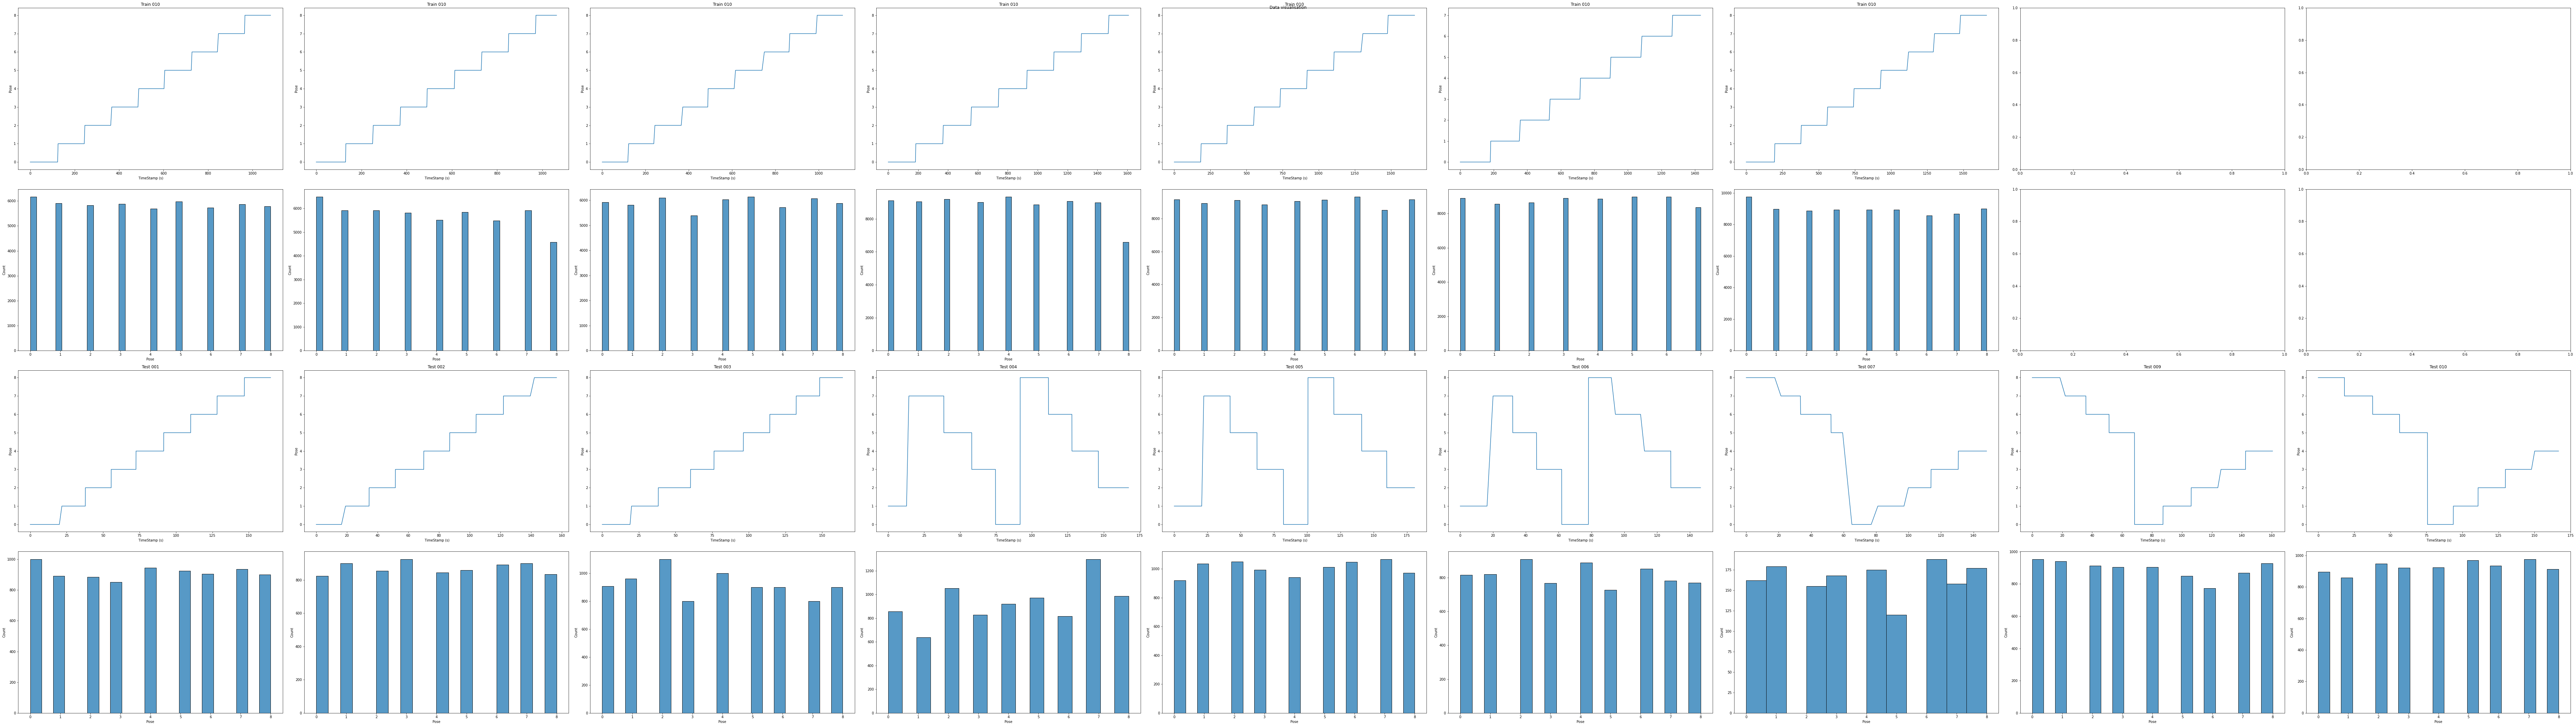

In [5]:
cols = []
height=30
width=(height/2)*len(x_train_arr)
fig, axes = plt.subplots(4,  max(len(training_files), len(testing_files)), figsize=(width, height))
fig.suptitle('Data visualisation')
# Train
for i in range(len(x_train_arr)):
    sns.lineplot(ax=axes[0, i], data=x_train_arr[i].df, x=" TimeStamp (s)", y='Pose')
    sns.histplot(ax=axes[1, i], data=x_train_arr[i].df["Pose"])
    cols.append(f'Train {key}')    
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
# Test
cols=[]
for i, key in enumerate(x_test_dict):
    sns.lineplot(ax=axes[2, i], data=x_test_dict[key], x=" TimeStamp (s)", y='Pose')
    sns.histplot(ax=axes[3, i], data=y_test_dict[key])
    cols.append(f'Test {key}')
for ax, col in zip(axes[2], cols):
    ax.set_title(col)
fig.tight_layout()
plt.show()

## Adjust dataframes

In [6]:
x_train_numpy = x_train.values
x_test_numpy = x_test.values
y_train_numpy = y_train.values
y_test_numpy = y_test.values

### GridSearch

In [7]:
"""
n_estimators_lst = [i for i in range(75, 125)]
parameters = {'n_estimators':n_estimators_lst} 
rfc = RandomForestClassifier(random_state=69)
clf = GridSearchCV(rfc, parameters, n_jobs=-1)
clf.fit(x_train, y_train)
"""


"\nn_estimators_lst = [i for i in range(75, 125)]\nparameters = {'n_estimators':n_estimators_lst} \nrfc = RandomForestClassifier(random_state=69)\nclf = GridSearchCV(rfc, parameters, n_jobs=-1)\nclf.fit(x_train, y_train)\n"

## RFC            

In [8]:
#pipe = make_pipeline(RandomForestClassifier(n_estimators=140, random_state=42))
#pipe = RandomForestClassifier(random_state=42)
"""pipe.fit(x_train,y_train)"""

'pipe.fit(x_train,y_train)'

## Precision

In [11]:
import math
import numpy
from sklearn.model_selection import KFold,RepeatedStratifiedKFold, cross_val_score
"""best = [62.82,78.52,0]
curr = [0,0,0]
best_estimators = [25,0,0]
max_estimators = 21
"""
estimators = 50



def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores


def get_models_features():
	models = dict()
	# explore number of features from 1 to 7
	for i in range(1,(
        AMOUNT_OF_SENSORS*13)+1):
		models[str(i)] = RandomForestClassifier(max_features=i, random_state=42)
	return models

def get_models_samples(n_estimators=10, max_features=3):
    models = dict()
    # explore ratios from 10% to 100% in 10% increment
    for i in numpy.arange(0.1, 1.1, 0.1):
        key = '%.1f' % i
        # set max_samples=None to use 100%
        if i == 1.0:
            i = None
        models.append({i, RandomForestClassifier(max_samples=i, random_state=33, max_features=max_features, n_estimators=n_estimators)})
        print(i)
    return models

def find_oob_err_with_trees():
    # Find best amount of trees
    n_estimators = []
    oob_err = []
    for i in range(1, 100):
        rfc = RandomForestClassifier(n_estimators=i, max_features=3, oob_score=True, random_state=33, max_samples=0.5)
        rfc.fit(x_train, y_train)
        print("rfc oob_score: ", rfc.oob_score_)
        err = 1-rfc.oob_score_
        
        print("1-oob_score: ", err)
        oob_err.append(err)
        n_estimators.append(i)
    return (n_estimators, oob_err)

def find_test_accuracy(model, x, y):
    model.fit(x_train, y_train)
    print("Classification accuracy:")
    classification_dict = dict()
    accuracy_list = list()

    for key in x_test_dict:
        x_test = x_test_dict[key].drop([' TimeStamp (s)', 'Pose'], axis=1)
        classifications = model.predict(x_test)
        annotated_positions = y_test_dict[key].to_numpy()
        correct_classifications = (classifications == annotated_positions).sum()
        accuracy_list.append(round(correct_classifications/len(classifications)*100,2))
        print(f"{key}: {accuracy_list[-1]}%")
        classification_dict[key] = classifications

    avg = round(sum(accuracy_list)/len(accuracy_list),2)
    print(f"Average accuracy: {avg}%\nWith {estimators} estimators and\nrandom_state={33}")
    return avg


#Plot oob_err based on amount of estimators...
"""n_estimators, oob_errs = find_oob_err_with_trees()
plt.plot(n_estimators, oob_errs)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.show()"""

#model = RandomForestClassifier(max_features=3, random_state=33, n_estimators=estimators, max_samples=0.5)
#score = evaluate_model(model, x_train, y_train)
#print(score)
# avg_on_sets = find_test_accuracy(model, x_train, y_train)

feature_models = get_models_features()
averages = []
for i in range(len(feature_models)):
    averages.append(find_test_accuracy(feature_models[str(i+1)], x_train, y_train))
best_feature_amount = averages.index(max(averages))+1
print("best_featue_amount: ", best_feature_amount)

sample_models = get_models_samples(max_features=best_feature_amount)
sample_averages = []
for i in range(len(sample_models)):
    averages.append(find_test_accuracy(sample_models.values()[i], x_train, y_train))
best_sample_amount = sample_models.keys()[sample_averages.index(max(averages))]
print("best_sample_amount: ", best_sample_amount)

model = RandomForestClassifier(max_samples=best_sample_amount, max_features=best_feature_amount, random_state=33, n_estimators=100)

"""
#Get best features
#for feature_models in sample_models:
feature_models = RandomForestClassifier(max_features=3, random_state=33, n_estimators=estimators) #get_models_features()

results = []
for m in feature_models:
    feature_models.fit(x_train,y_train)
    print("Classification accuracy:")
    classification_dict = dict()
    accuracy_list = list()

    for key in x_test_dict:
        x_test = x_test_dict[key].drop([' TimeStamp (s)', 'Pose'], axis=1)
        classifications = feature_models.predict(x_test)
        annotated_positions = y_test_dict[key].to_numpy()
        correct_classifications = (classifications == annotated_positions).sum()
        accuracy_list.append(round(correct_classifications/len(classifications)*100,2))
        print(f"{key}: {accuracy_list[-1]}%")
        classification_dict[key] = classifications

    avg = round(sum(accuracy_list)/len(accuracy_list),2)
    results.append(avg)
    curr[AMOUNT_OF_SENSORS-1] = avg
    if avg > best[AMOUNT_OF_SENSORS-1]:
        best[AMOUNT_OF_SENSORS-1] = avg
        best_estimators[AMOUNT_OF_SENSORS-1] = estimators
    print(f"Average accuracy: {avg}%\nWith {estimators} estimators and\nrandom_state={i}")"""


KeyboardInterrupt: 

## Visualization


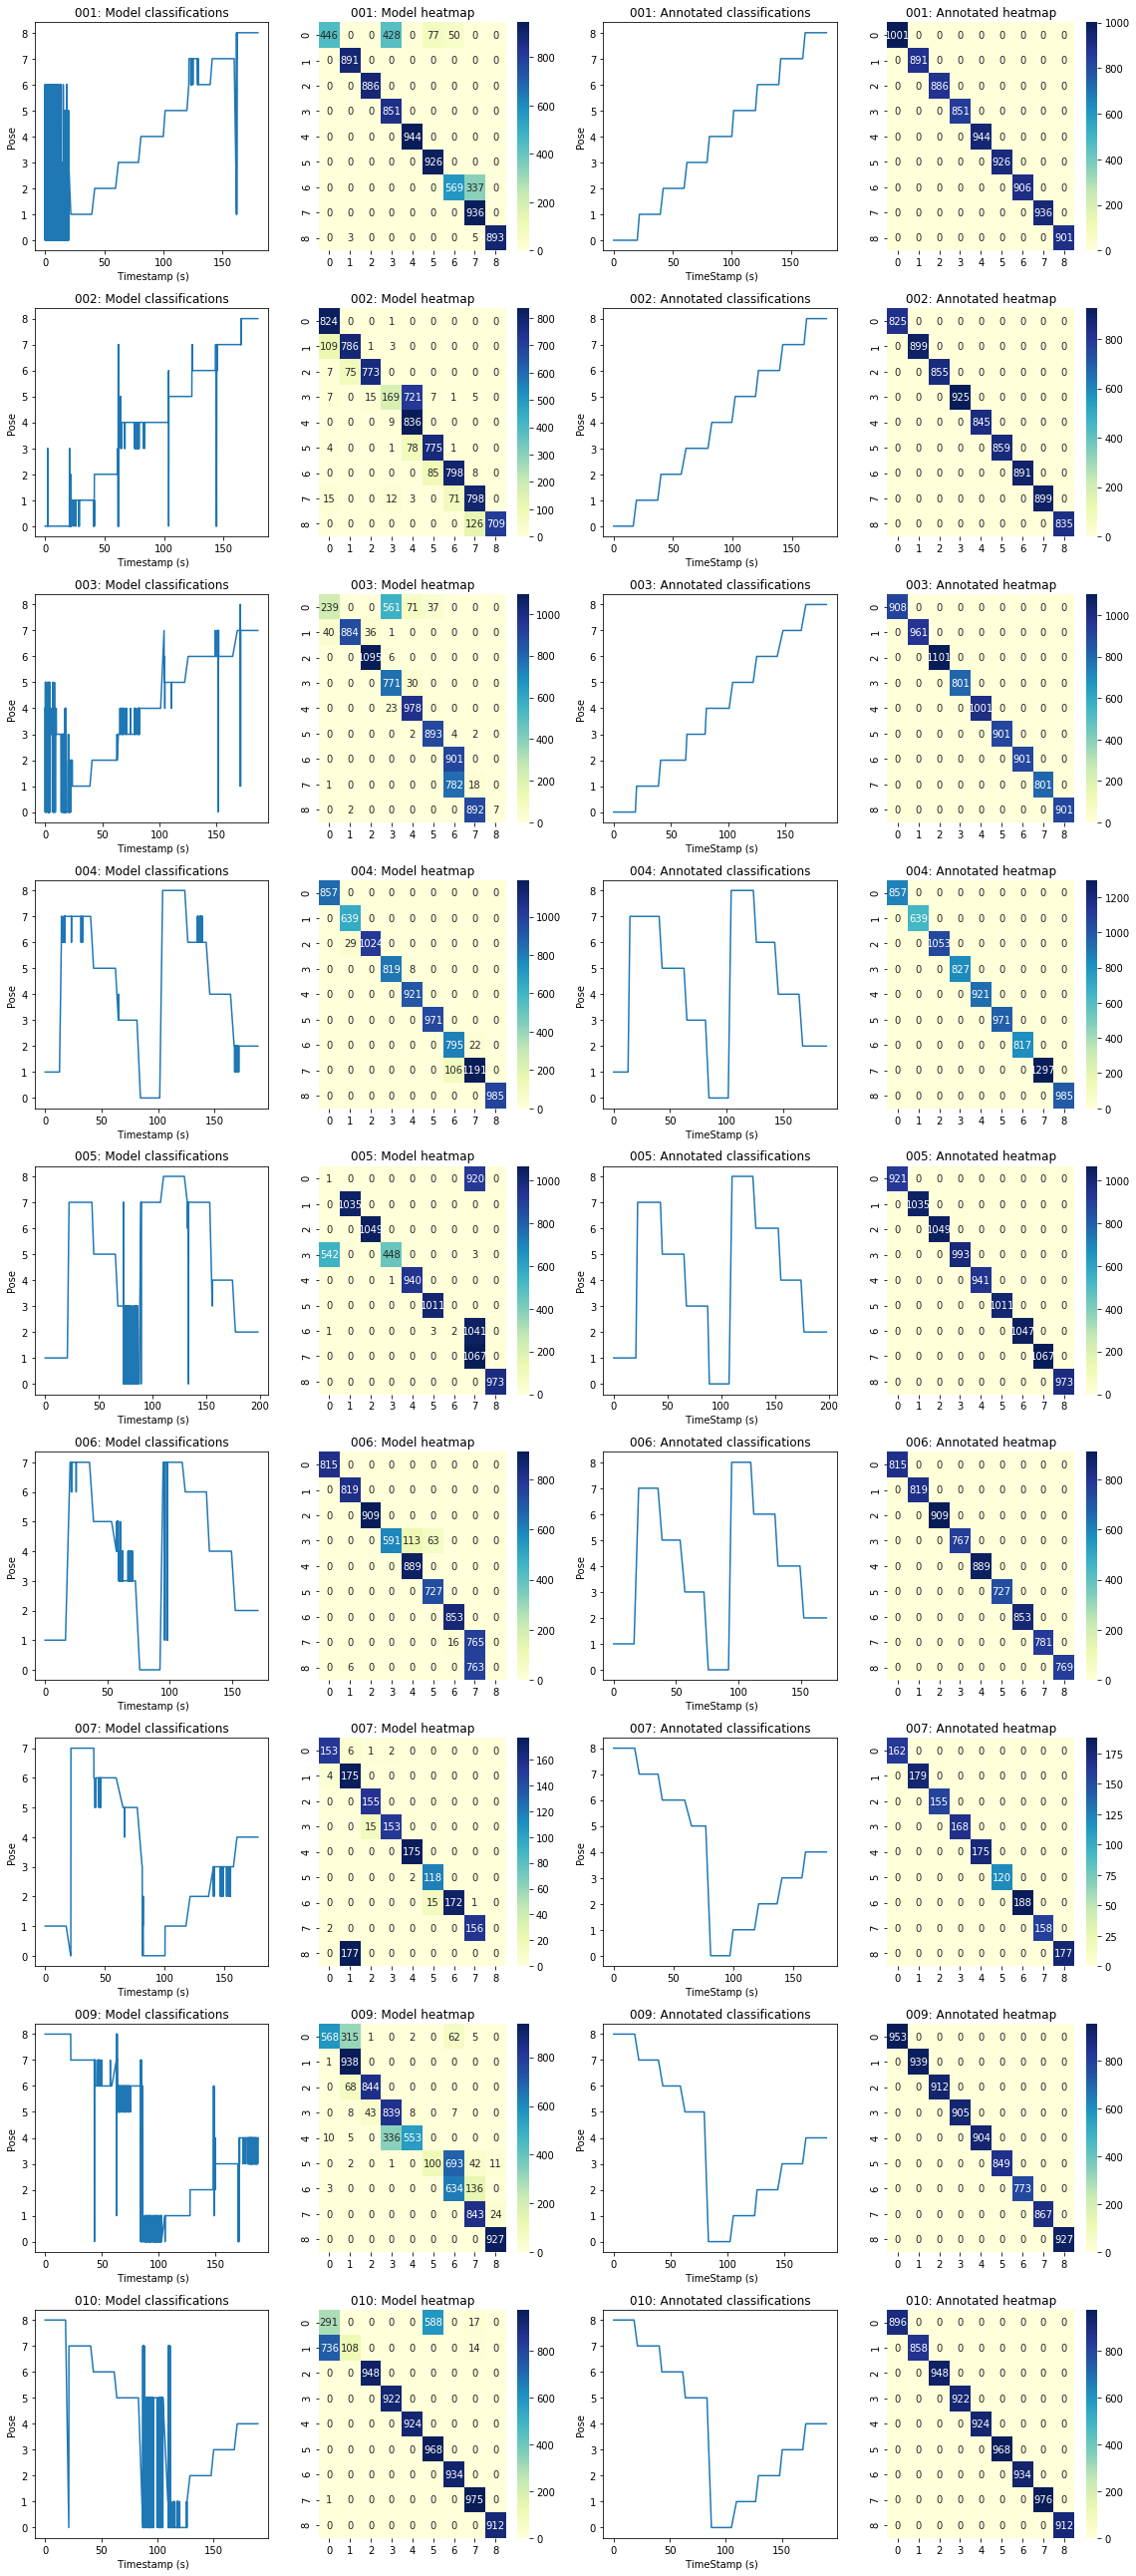

In [ ]:
width=16
height=4*len(x_test_dict)
fig, axes = plt.subplots(len(x_test_dict), 4, figsize=(width, height))
for i, key in enumerate(x_test_dict):
    cols = [f"{key}: Model classifications", f"{key}: Model heatmap", f"{key}: Annotated classifications", f"{key}: Annotated heatmap"]
    df_predict = pd.DataFrame({' Timestamp (s)': x_test_dict[key][' TimeStamp (s)'],'Pose':classification_dict[key]})
    sns.lineplot(ax=axes[i, 0], data=df_predict,x=' Timestamp (s)',y='Pose')
    sns.heatmap(ax=axes[i, 1], data=confusion_matrix(y_test_dict[key], classification_dict[key]), cmap="YlGnBu", annot=True, fmt="d")
    sns.lineplot(ax=axes[i, 2], data=x_test_dict[key], x=" TimeStamp (s)", y='Pose')
    sns.heatmap(ax=axes[i, 3], data=confusion_matrix(y_test_dict[key], y_test_dict[key].to_numpy()), cmap="YlGnBu", annot=True, fmt="d")
    for ax, col in zip(axes[i], cols): ax.set_title(col)
fig.tight_layout()
plt.show()

## Classification matrix and report

In [ ]:
from sklearn.model_selection import cross_val_score
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring=’roc_auc’)

SyntaxError: invalid character in identifier (<ipython-input-11-d9ee30d84370>, line 2)

In [ ]:

from joblib import dump, load
dump(pipe, f'../models/RFC_model_{AMOUNT_OF_SENSORS}.joblib')


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=59d486bc-e14d-4632-9064-12272fc72d11' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>